# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

### Time Series analysis

#### Business Understanding 


#### Objectives 
1. Find the top ZipCodes. 
2. Develop a Time-Series regression model to predict house prices for the next 6 months. 
3. Investigate change of house prices in the top ten States with the most high priced houses. 


In [1]:
import pandas as pd 
import numpy as np 
import itertools 

# Modelling libraries
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import r2_score, mean_squared_error 
from prophet import Prophet 
from neuralprophet import NeuralProphet 
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima import auto_arima 

# Visualization libraries
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.tight_layout 
import seaborn as sns 
# Graph Fonts 
plt.rcParams['font.size'] = 12 

import warnings
warnings.filterwarnings('ignore')   

import joblib 


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


### Data Understanding 
We seek out to understand the Zillow data provided containing average house prices. 
1. Check the data information.
2. Check for missing values.
3. Check for duplicated values. 

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [3]:
df.tail()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,93700.0,93400.0,93200.0,93000.0,92900.0,92700.0,92600.0,92600.0,92600.0,92800.0,93100.0,93500.0,94000.0,94500.0,95100.0,95800.0,96500.0,97100.0,97800.0,98500.0,99200.0,100000.0,100800.0,101700.0,102600.0,103400.0,104200.0,104900.0,105600.0,106300.0,106800.0,107300.0,107800.0,108400.0,109000.0,109600.0,110200.0,110800.0,111400.0,112000.0,112600.0,113000.0,113500.0,113900.0,114300.0,114800.0,115400.0,116000.0,116700.0,117400.0,118100.0,118700.0,119500.0,120100.0,120600.0,121100.0,121700.0,122400.0,123300.0,124200.0,125300.0,126300.0,127400.0,128500.0,129600.0,130600.0,131400.0,132100.0,133000.0,133900.0,134900.0,136000.0,137200.0,138500.0,139700.0,140900.0,141900.0,143600.0,146300.0,149100.0,150900.0,151800.0,152000.0,151700.0,151700.0,152500.0,154200.0,156700.0,159800.0,163000.0,166000.0,168700.0,171400.0,174100.0,176800.0,179200.0,180800.0,181800.0,182400.0,182800.0,183200.0,183700.0,184300.0,185400.0,187300.0,190000.0,193400.0,197200.0,200600.0,203100.0,204400.0,205000.0,205300.0,205400.0,205500.0,205300.0,205100.0,204800.0,204800.0,204900.0,205200.0,205700.0,206200.0,206500.0,206500.0,206300.0,206100.0,205900.0,205600.0,205000.0,204100.0,202900.0,201600.0,200200.0,198900.0,197800.0,197100.0,196900.0,197300.0,197900.0,198100.0,197800.0,197200.0,196400.0,195600.0,194600.0,193400.0,192200.0,191300.0,190800.0,190700.0,190500.0,189800.0,188700.0,187500.0,186700.0,186600.0,187100.0,187300.0,187500.0,187700.0,188200.0,189000.0,190100.0,190200.0,188500.0,186200.0,184400.0,184400.0,185900.0,188000.0,188900.0,188900.0,187600.0,183700.0,177100.0,173200.0,173000.0,174700.0,176200.0,176300.0,174700.0,174000.0,174800.0,175800.0,175500.0,174600.0,174700.0,175200.0,175400.0,175200.0,175300.0,174500.0,173100.0,172700.0,1732

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

The data has more than 200 columns and should be changed to a long formart. 
The data also does not have any duplicated values. 

The data is in a wide formart and therefore all the columns cannot be displayed to show the missing values. We can only see the Metro column which has 1043 missing values. Data in wide formart is had to do use because no preproccessing can be done it efficiently. Our objectives are tied to the date column and therefore necessarry to convert the data into a long formart for easy analysis. 

### Data Filtering

# Step 2: Data Preprocessing

This step involves engineering new features that may help in understanding the data more better and do anefficient analysis. 
1. Convert the data from the wide to long formart. 
2. Convert the time column into a datetime column. 
3. Engineer new features for the month and year column from the date column. 

In [7]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName','RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna()
    return melted 

In [8]:
df_eda = melt_data(df)

To get the top zipcodes the real estate investors can invest in, we use the metro politan areas which normally have a higher population with alot of industrail activities. Most of the houses in these regions always have ready markert for houses and this is what we will use in generating predictions and observe the significant increase of house value. 

Most metropolitan areas have high tenant properties and these guarantee a good **Return on Investment**.

In [9]:
group_metropolitan = pd.DataFrame(df_eda.groupby(['Metro','RegionName'])['value'].agg('mean').sort_values(ascending=False).head(30))
group_metropolitan 

value
Metro                          RegionName              
New York                       10021       1.285427e+07
                               10011       7.755844e+06
                               10014       6.836902e+06
                               10128       5.085436e+06
San Francisco                  94027       3.487129e+06
Glenwood Springs               81611       3.147124e+06
Los Angeles-Long Beach-Anaheim 90210       2.789977e+06
Miami-Fort Lauderdale          33480       2.634498e+06
San Francisco                  94123       2.630977e+06
Brunswick                      31561       2.403194e+06
San Francisco                  94115       2.399030e+06
                               94109       2.395636e+06
Glenwood Springs               81615       2.300179e+06
Los Angeles-Long Beach-Anaheim 90402       2.292232e+06
San Diego                      92067       2.170122e+06
Los Angeles-Long Beach-Anaheim 90020       2.149644e+06
San Francisco                  94028       2.131495e+06
San Jose                       94301       2.084380e+06
New York                       7620        2.080074e+06
Los Angeles-Long Beach-Anaheim 92657       2.070006e+06
San Jose                       94022       2.066818e+06
San Francisco                  94957       2.043843e+06
Santa Maria-Santa Barbara      93108       1.991682e+06
New York                       11217       1.977407e+06
San Jose                       94305       1.918675e+06
Boston                         2116        1.887043e+06
Los Angeles-Long Beach-Anaheim 90265       1.876195e+06
San Francisco                  94133       1.833388e+06
New York                       11976       1.803404e+06
Los Angeles-Long Beach-Anaheim 90049       1.799291e+06

In [10]:
df_eda.reset_index(inplace=True)
df_eda.head()

,index,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,2,77494,91982,3,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [11]:
df_eda['Year'] = df_eda['time'].dt.year
df_eda['Month'] = df_eda['time'].dt.month 

<AxesSubplot: xlabel='State', ylabel='value'>

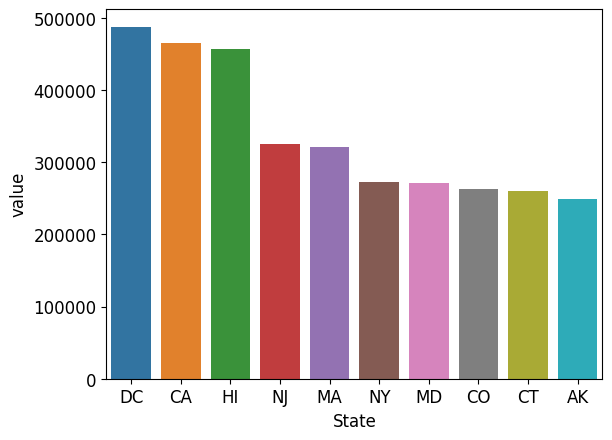

In [12]:
# Average house prices by state 
state_group = df_eda.groupby('State')['value'].agg('mean').sort_values(ascending=False).head(10)

sns.barplot(data=state_group.reset_index(), x='State', y='value')

<AxesSubplot: xlabel='value', ylabel='Count'>

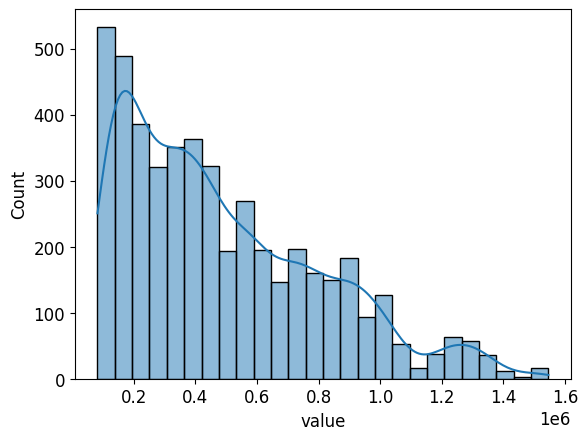

In [13]:
# Filter data to only include the data from DC because it seems to be the most expensive houses 
dc_slice = df_eda[df_eda['State'] == 'DC'] 
# House price distribution prices in new York 
sns.histplot(data=dc_slice, x='value', kde=True)

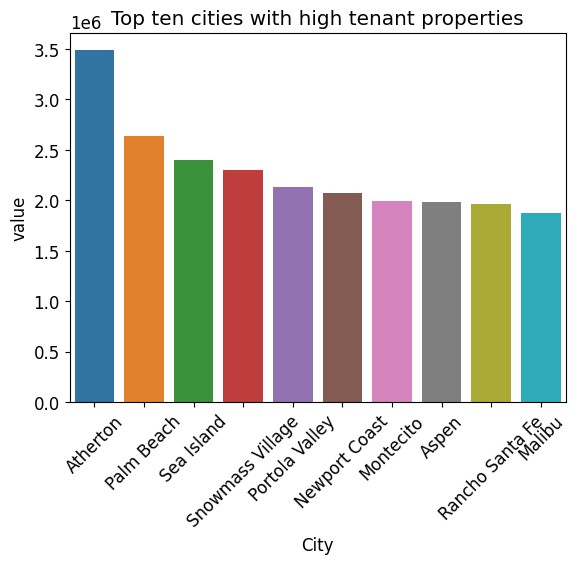

In [14]:
group_cities = pd.DataFrame(df_eda.groupby('City')['value'].agg('mean').sort_values(ascending=False)).head(10)

sns.barplot(data=group_cities.reset_index(), x='City', y='value')
plt.title("Top ten cities with high tenant properties")
plt.xticks(rotation=45)
plt.show() 

In [15]:
# import bar_chart_race as br 

# bar = br.bar_chart_race(df=bar_animation, filename=None, figsize=(3.5,3), title="House price changes by state")

# Step 3: EDA and Visualization

# Step 4: Modelling

In [16]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName','RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna()
    return melted 

In [17]:
df_model = melt_data(df)
df_model.set_index('time', inplace=True)

In [18]:
df_model.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,60657,84654,1,Chicago,IL,Chicago,Cook,334200.0
1996-04-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,235700.0
1996-04-01,77494,91982,3,Katy,TX,Houston,Harris,210400.0
1996-04-01,60614,84616,4,Chicago,IL,Chicago,Cook,498100.0
1996-04-01,79936,93144,5,El Paso,TX,El Paso,El Paso,77300.0


In [19]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

<AxesSubplot: xlabel='time'>

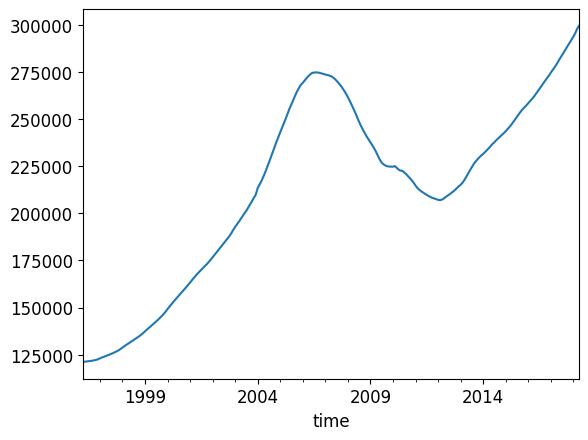

In [20]:
df_model2 = df_model['value'].resample('MS').mean()
df_model2.plot()

In [21]:
def corr_plots(data):
    acf_diff = plot_acf(data)
    pacf_plot = plot_pacf(data)
    
    return acf_diff, pacf_plot 

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

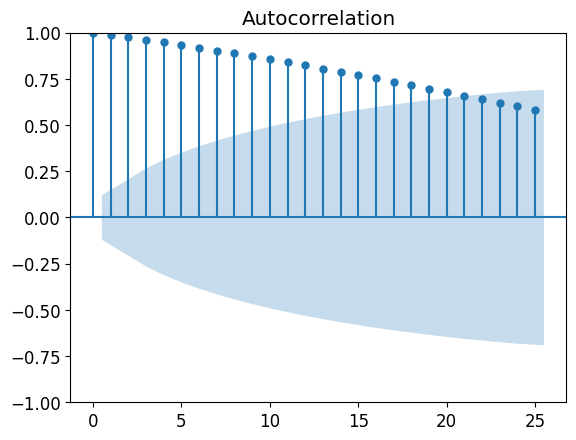

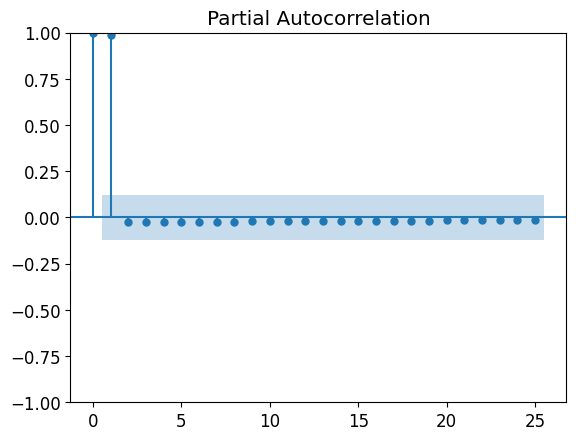

In [22]:
corr_plots(df_model2)

We now use the zipcodes that seemed to have the highest prices in metropolitan areas to do the forecasting process.  

In [23]:

unique_counties = [10021, 10011, 10014, 10128, 94027, 81611, 90210, 33480, 94123, 31561,
                   94115, 94109, 81615, 90402, 92067, 90020, 94028, 94301, 7620, 92657,
                   94022, 94957, 93108, 11217, 94305, 2116, 90265, 94133, 11976, 90049]

tsc = TimeSeriesSplit(n_splits=5)

all_train_dates, all_test_dates = [], []
all_train_values, all_test_values = [], []
all_forecasts = []

results_list = []

for county in unique_counties:
    county_data = df_model[df_model['RegionName'] == county]

    # Split the data 
    dates = county_data.index
    values = county_data['value'].values

    # accumulate values for each fold
    zip_train_dates, zip_test_dates = [], []
    zip_train_values, zip_test_values = [], []

    for train_index, test_index in tsc.split(dates):
        train_dates, test_dates = dates[train_index], dates[test_index]
        train_values, test_values = values[train_index], values[test_index]

        zip_train_dates.extend(train_dates)
        zip_test_dates.extend(test_dates)
        zip_train_values.extend(train_values)
        zip_test_values.extend(test_values)

        
        baseline_model = ARIMA(train_values, order=(1, 0, 1)).fit()
        forecast = pd.Series(baseline_model.predict(start=len(train_values), end=len(train_values) + 11, typ='levels'))

        all_forecasts.extend(forecast)

    
        forecasted_value = forecast.iloc[-1]
        real_value = test_values[-1]
        percentage_change = ((forecasted_value - real_value) / real_value) * 100

        results_list.append({'County': county, 'Forecast': forecasted_value, 'Real': real_value, 'Percentage Change': percentage_change})


results_df = pd.DataFrame(results_list)

In [26]:
results_df 


,County,Forecast,Real,Percentage Change
0,10021,9.830246e+06,10883800.0,-9.680016
1,10021,1.077231e+07,13043800.0,-17.414338
2,10021,1.275458e+07,11630200.0,9.667799
3,10021,1.158979e+07,18341500.0,-36.811086
4,10021,1.814077e+07,17894900.0,1.373952
...,...,...,...,...
145,90049,1.003389e+06,1567600.0,-35.991998
146,90049,1.577039e+06,2163800.0,-27.117155
147,90049,2.159892e+06,1672400.0,29.149234
148,90049,1.673893e+06,2472600.0,-32.302311


In [161]:
# unique_counties = results_df['County'].unique()

# for county in unique_counties:
#     county_data = results_df[results_df['County'] == county]

#     # Create a bar chart for each county
#     plt.figure(figsize=(10, 6))
#     plt.bar(county_data.index, county_data['Forecast'], width=0.4, label='Forecasted Price', color='blue')
#     plt.bar(county_data.index + 0.4, county_data['Real'], width=0.4, label='Actual Price', color='green')

#     # Add labels and title
#     plt.xlabel('Sample')
#     plt.ylabel('Price')
#     plt.title(f'Predicted vs Actual Prices - County {county}')
#     plt.xticks(county_data.index + 0.2, range(len(county_data)))

#     # Add legend
#     plt.legend()

#     # Show the plot
#     plt.show()

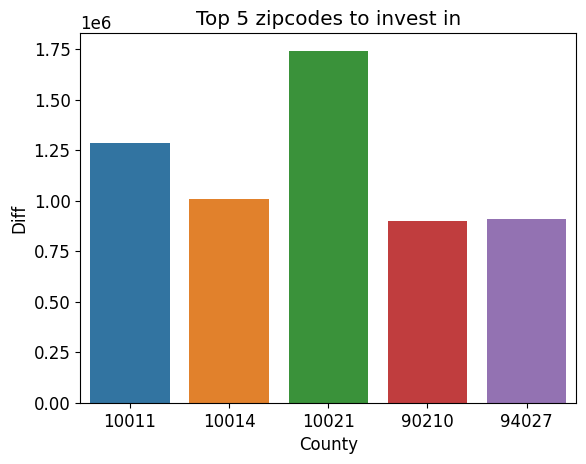

In [27]:
avg_results = results_df.groupby('County')[['Forecast', 'Real']].mean().reset_index()
avg_results['Diff'] =avg_results['Real'] - avg_results['Forecast']
top_5 = avg_results.sort_values(by='Diff', ascending=False).head(5)
sns.barplot(data=top_5, x='County', y='Diff')
plt.title("Top 5 zipcodes to invest in")
plt.show()

After doing forecasting on the slected zipcodes, using a baseline model, we go ahead and try to use the auto arima to gte the lowest AIC scores ad later use a loop that will seek to reduce the RMSE. These are all the metrics to analyze the perforamnce of our model. 

In [124]:
for county in unique_counties:
    county_data = df_model[df_model['RegionName'] == county]

    # Split the data 
    dates = county_data.index
    values = county_data['value'].values

    # accumulate values for each fold
    zip_train_dates, zip_test_dates = [], []
    zip_train_values, zip_test_values = [], []

    for train_index, test_index in tsc.split(dates):
        train_dates, test_dates = dates[train_index], dates[test_index]
        train_values, test_values = values[train_index], values[test_index]

        zip_train_dates.extend(train_dates)
        zip_test_dates.extend(test_dates)
        zip_train_values.extend(train_values)
        zip_test_values.extend(test_values)

        
        auto_model = auto_arima(train_values, trace=True, suppress_warnings=True)
        auto_model.summary()
    

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=798.472, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=991.727, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=983.334, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1124.743, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=858.266, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=783.861, Time=0.28 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=833.611, Time=0.16 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=770.890, Time=0.27 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=823.210, Time=0.15 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=779.522, Time=0.50 sec
 

We go ahead and apply the best pdq combinations to the arima baseline model. This seeks to minimize the AIC scores.

In [28]:
results_list2 = []

for county in unique_counties:
    county_data = df_model[df_model['RegionName'] == county]

    # Split the data 
    dates = county_data.index
    values = county_data['value'].values

    # accumulate values for each fold
    zip_train_dates, zip_test_dates = [], []
    zip_train_values, zip_test_values = [], []

    for train_index, test_index in tsc.split(dates):
        train_dates, test_dates = dates[train_index], dates[test_index]
        train_values, test_values = values[train_index], values[test_index]

        zip_train_dates.extend(train_dates)
        zip_test_dates.extend(test_dates)
        zip_train_values.extend(train_values)
        zip_test_values.extend(test_values)

        
        baseline_model3 = ARIMA(train_values, order=(0, 2, 0)).fit()
        forecast = pd.Series(baseline_model3.predict(start=len(train_values), end=len(train_values) + 11, typ='levels'))

        all_forecasts.extend(forecast)

    
        forecasted_value = forecast.iloc[-1]
        real_value = test_values[-1]
        percentage_change = ((forecasted_value - real_value) / real_value) * 100

        results_list2.append({'County': county, 'Forecast': forecasted_value, 'Real': real_value, 'Percentage Change': percentage_change})


results_df2 = pd.DataFrame(results_list2)
 


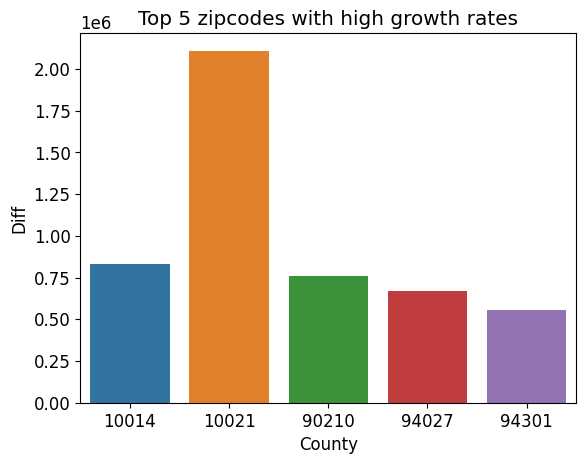

In [29]:
avg_results2 = results_df2.groupby('County')[['Forecast', 'Real']].mean().reset_index()
avg_results2['Diff'] =avg_results['Real'] - avg_results2['Forecast']
top_5 = avg_results2.sort_values(by='Diff', ascending=False).head(5)
sns.barplot(data=top_5, x='County', y='Diff')
plt.title("Top 5 zipcodes with high growth rates")
plt.show()

#### FaceBook Prophet 

In [30]:
df_model.reset_index(inplace=True)

In [31]:
# Create a csv file for the selected zip codes and to be used in the Prophet pipeline. 
for county in unique_counties:
    county_data = df_model[df_model['RegionName'] == county][['time', 'value']].copy()
    county_data.to_csv('Zipcode_predict.csv')

16:26:49 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing


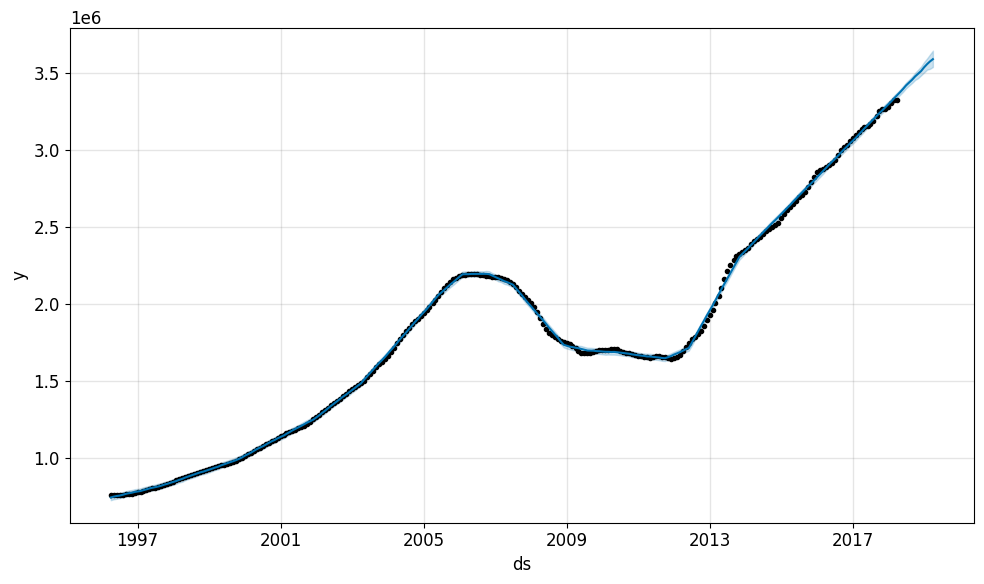

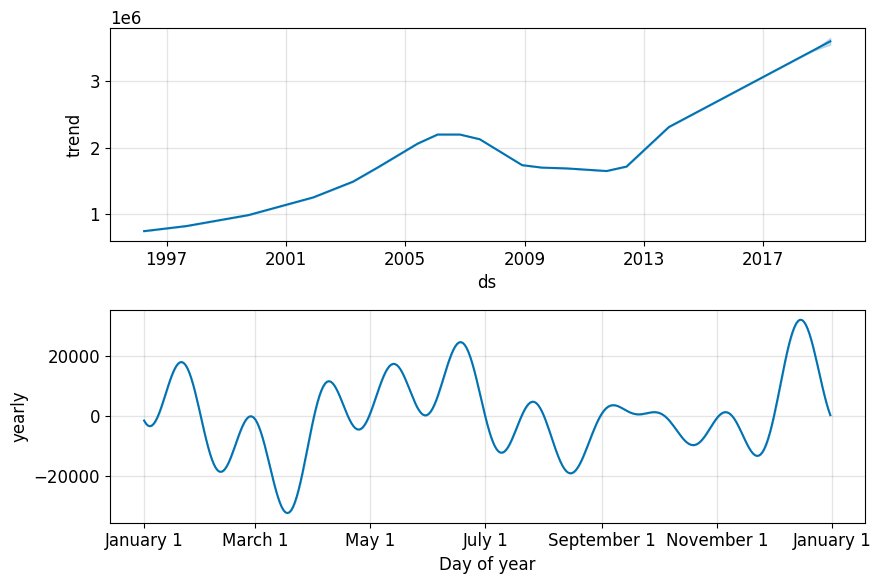

In [32]:
# An ETL Pipeline using traditional OOP method 
class TimeSeriesPipeline:
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = None
        self.model = None
        self.forecast = None

    def load_data(self):
        self.data = pd.read_csv(self.data_path)

    def preprocess_data(self, target_column='y', ds_column='ds'):
        self.data[ds_column] = pd.to_datetime(self.data[ds_column])
        self.data = self.data.rename(columns={ds_column: 'ds', target_column: 'y'})
        
        if self.data.duplicated('ds').any():
            self.data = self.data.drop_duplicates(subset='ds', keep='first')      

    def train_model(self):
        self.model = Prophet()
        
        self.model.fit(self.data)

    def make_predictions(self, periods=12):
        future = self.model.make_future_dataframe(periods=periods, freq='M')
        self.forecast = self.model.predict(future)

    def plot_forecast(self):
        fig = self.model.plot(self.forecast)
        fig2 = self.model.plot_components(self.forecast);
        plt.show()
        
    def evaluate_model(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        return mse, rmse, r2 


    def run_pipeline(self, target_column='y', ds_column='ds',periods=12):
        self.load_data()
        self.preprocess_data(target_column=target_column, ds_column=ds_column)
        self.train_model()
        self.make_predictions(periods=periods)
        self.plot_forecast() 
        
# Class to save the model and forecast       
class SaveModel(TimeSeriesPipeline):
    def save_model(self, model_path='house_predictor.pkl'):
       joblib.dump(self.model, model_path)

    def save_forecast(self, forecast_path='house_forecast.pkl'):
       joblib.dump(self.forecast, forecast_path)

        
data_path = "Zipcode_predict.csv"
target_column = 'y'
pipeline = SaveModel(data_path) 
pipeline.run_pipeline(target_column='value', ds_column='time', periods=12)
pipeline.save_model()
pipeline.save_forecast()

#### Neural Prophet

In [226]:
# from sklearn.metrics import mean_absolute_error 
# class TimeSeriesPipeline2:
#     def __init__(self, data_path):
#         self.data_path = data_path
#         self.data = None
#         self.model = None
#         self.forecast = None

#     def load_data(self):
#         self.data = pd.read_csv(self.data_path)

#     def preprocess_data(self, target_column='y', ds_column='ds'):
#         self.data[ds_column] = pd.to_datetime(self.data[ds_column])
#         self.data = self.data.rename(columns={ds_column: 'ds', target_column: 'y'})
        
#         if self.data.duplicated('ds').any():
#             self.data = self.data.drop_duplicates(subset='ds', keep='first')

            

#     def train_model(self, growth='linear', yearly_seasonality=True, epochs=40):
#         self.model = NeuralProphet(
#             growth=growth,
#             yearly_seasonality=yearly_seasonality,
#             epochs=epochs  
#         )
#         self.model.fit(self.data)

#     def make_predictions(self, periods=365):
#         future = self.model.make_future_dataframe(periods=periods)
#         self.forecast = self.model.predict(future)

#     def plot_forecast(self):
#         fig = self.model.plot(self.forecast)
#         plt.show()
        
#     def evaluate_model(self, y_true, y_pred):
#         mae = mean_absolute_error(y_true, y_pred)
#         mse = mean_squared_error(y_true, y_pred)
#         rmse = np.sqrt(mse)
#         r2 = r2_score(y_true, y_pred)

#         return mae, mse, rmse, r2


#     def run_pipeline(self, target_column='y', ds_column='ds', growth='linear', yearly_seasonality=True, periods=365):
#         self.load_data()
#         self.preprocess_data(target_column=target_column, ds_column=ds_column)
#         self.train_model(growth=growth, yearly_seasonality=yearly_seasonality)
#         self.make_predictions(periods=periods)
#         self.plot_forecast() 
        
        

# data_path = "Zipcode_predict.csv"
# target = ['y']
# pipeline = TimeSeriesPipeline2(data_path)
# pipeline.run_pipeline(target_column= 'y' , ds_column='ds', growth='linear', yearly_seasonality=True, periods=365)


In [203]:
df4 = pd.read_csv("Zillow_resampled_new.csv")
df4.drop(columns='Unnamed: 0', axis=1)
df4.to_csv("Zillow_resampled_new.csv")

In [227]:

# p = range(0,8)
# q = range(0,8)
# d = range(0,2)

# pdq_combinations = list(itertools.product(p,d,q))

# aic_scores = []
# rmse = []
# order_1 = []

# for pdq in pdq_combinations:
#     try:
#         model = ARIMA(train, order=pdq).fit()
#         pred = model.predict(start=len(train), end=len(train)+ len(test)-1, typ='levels')
#         error = np.sqrt(mean_squared_error(pred, test['value']))
#         aic = model.aic 
#         aic.append(aic_scores)
#         order_1.append(pdq)
#         rmse.append(error) 
#     except:
#         continue 
    
# results = pd.DataFrame(index=order_1, data={'RMSE': rmse, 'AIC': aic_scores})
# # results.to_csv("combinations.csv") 
# print(results)

The optimum pdq values are saved in a csv file. These pdq values help to attain to make a data stationary during the training process. 

In [228]:
# stepwise = auto_arima(train['value'], trace=True, suppress_warnings=True)
# stepwise.summary()

In [55]:
baseline_model2 = ARIMA(train['value'], order=(1,1,0)).fit()
print(baseline_model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  219
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1549.175
Date:                Tue, 16 Jan 2024   AIC                           3102.350
Time:                        17:46:43   BIC                           3109.119
Sample:                    05-01-1996   HQIC                          3105.084
                         - 07-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2685      0.029     -9.398      0.000      -0.324      -0.212
sigma2      8.707e+04   2153.428     40.432      0.000    8.28e+04    9.13e+04
Ljung-Box (L1) (Q):                   0.00   Jarque-

# Step 5: ARIMA Modeling

In [ ]:
# def melt_data(df):
#     """
#     Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
#     Returns a long-form datetime dataframe 
#     with the datetime column names as the index and the values as the 'values' column.
    
#     If more than one row is passes in the wide-form dataset, the values column
#     will be the mean of the values from the datetime columns in all of the rows.
#     """
    
#     melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby(['time','RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName']).aggregate({'value':'mean'}).reset_index()

# Step 6: Interpreting Results